# Exponential Smoothing Model

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%cd ..

/home/williamglazer/Documents/school/projet/IFT6759_B_H23


In [2]:
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.models import ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import plot_residuals_analysis, extract_trend_and_seasonality

In [87]:
DATA_PATH = 'data/raw/exchange_rate/exchange_rate.txt'

# ETL

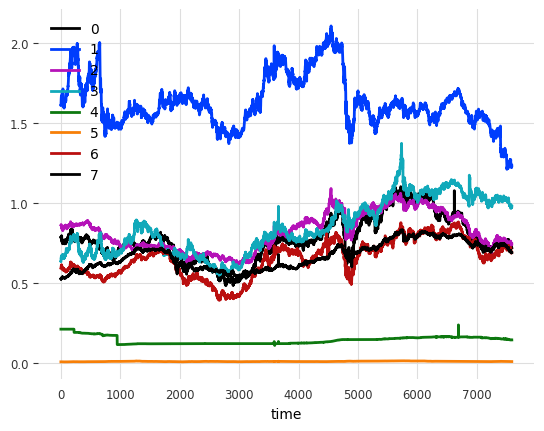

In [88]:
series = TimeSeries.from_csv(DATA_PATH, header=None)
series.plot()

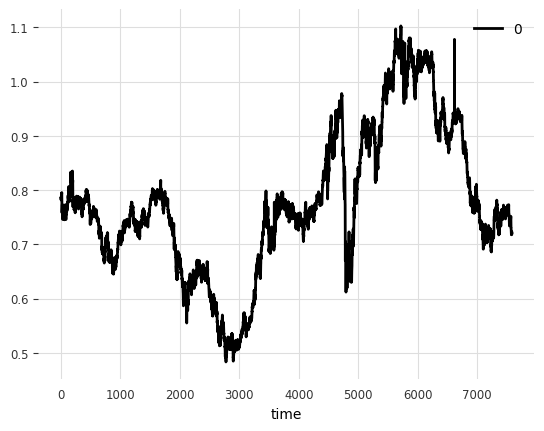

In [89]:
data = series.univariate_component(0)
data.plot()

In [93]:
# 80, 20, 20 split
train, test = data.split_before(0.80)
train, valid = train.split_before(0.75)

In [94]:
from darts.utils.utils import ModelMode, SeasonalityMode

params = {
    "seasonal": SeasonalityMode.ADDITIVE,
    "trend": SeasonalityMode.ADDITIVE,
}

## Check model performance over various horizons

We use the training set to estimate the performance of our model over various horizons

### Estimation without Covariates

In [54]:
HORIZONS = [7, 14, 31, 31*3, 31*6, 365]
errors, models = dict(), dict()

for horizon in HORIZONS:
    model = ExponentialSmoothing(**params)
    error = model.backtest(
        train,
        stride=min(horizon, 100),  # avoid overfit on strides/horizon
        start=0.2,
        metric=mape,
        forecast_horizon=horizon,
        retrain=True,
        verbose=True
    )

    models[horizon] = model
    errors[horizon] = error
    print(f"{error} - {model}")

  0%|          | 0/520 [00:00<?, ?it/s]

0.9324501976671019 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


  0%|          | 0/260 [00:00<?, ?it/s]

1.2851395761627744 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


  0%|          | 0/117 [00:00<?, ?it/s]

2.0250308909886106 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


  0%|          | 0/39 [00:00<?, ?it/s]

3.069033139993997 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


  0%|          | 0/35 [00:00<?, ?it/s]

4.558057263031539 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


  0%|          | 0/33 [00:00<?, ?it/s]

7.084242505637936 - ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=ModelMode.ADDITIVE, seasonal_periods=None


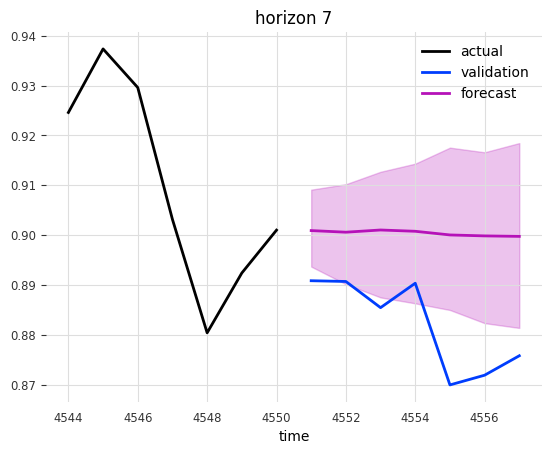

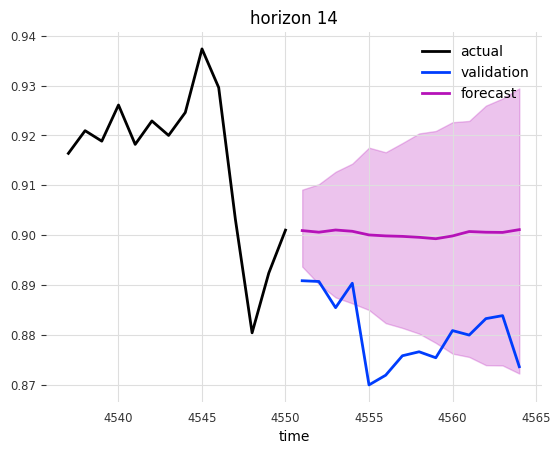

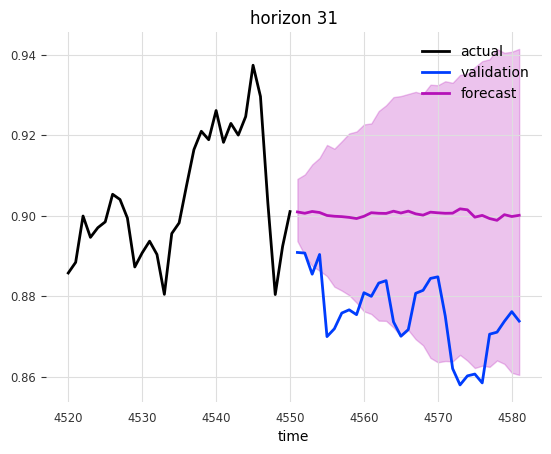

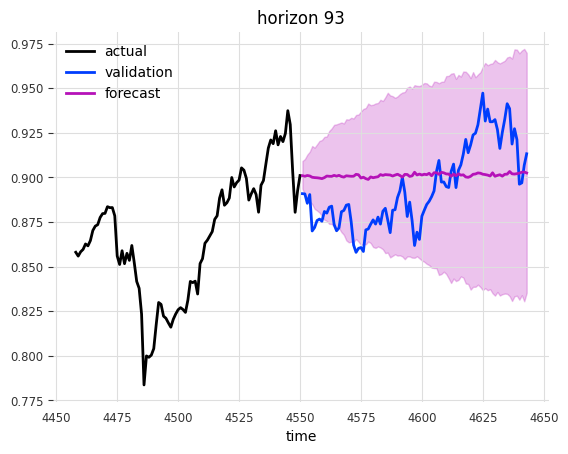

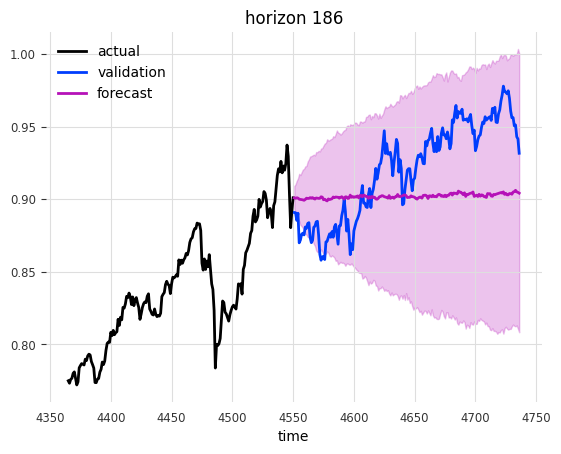

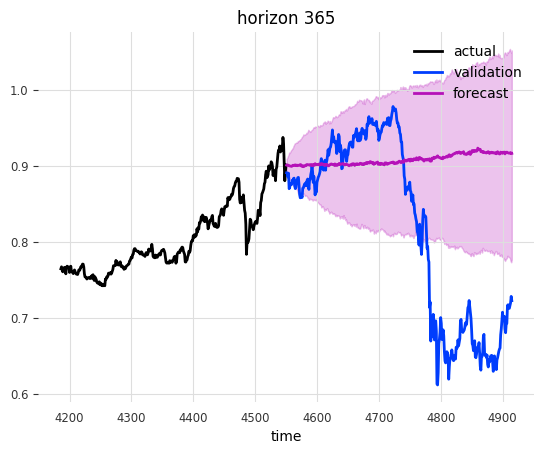

In [95]:
for horizon in HORIZONS:
    model = ExponentialSmoothing(**params)
    model.fit(train)
    forecast = model.predict(n=horizon, num_samples=500)

    train[-horizon:].plot(label='actual')
    valid[:horizon].plot(label='validation')
    forecast.plot(label='forecast')
    plt.title(f'horizon {horizon}')
    plt.show()

## Notes

**This model is slow at infer time**:
not suited for high dimensionnality since can only predict one Time Series at a time
This would take $O(nt)$ for $n$ the number of samples and $t$ the dimensionnality

**This model does not support covariates**
not suited for domains where correlations are strong

In [3]:
DATA_PATH = 'data/raw/traffic/traffic.txt'

# ETL

In [4]:
series = TimeSeries.from_csv(DATA_PATH, header=None)

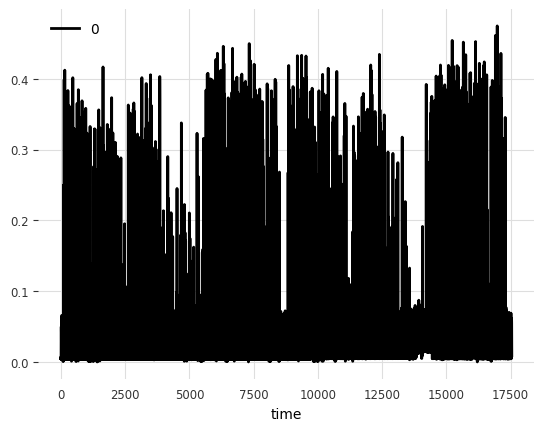

In [5]:
data = series.univariate_component(0)
data.plot()

In [6]:
# 80, 20, 20 split
train, test = data.split_before(0.80)
train, valid = train.split_before(0.75)

In [7]:
from darts.utils.utils import SeasonalityMode

params = {
    "seasonal": SeasonalityMode.ADDITIVE,
    "trend": SeasonalityMode.ADDITIVE,
    "seasonal_periods": 24  # 24H cycle
}

In [8]:
HORIZONS = [24, 24*2, 24*7, 24*31]
errors, models = dict(), dict()

for horizon in HORIZONS:
    model = ExponentialSmoothing(**params)
    error = model.backtest(
        train+1e-6,
        stride=min(horizon, 100),  # avoid overfit on strides/horizon
        start=0.2,
        metric=mape,
        forecast_horizon=horizon,
        retrain=True,
        verbose=True
    )

    models[horizon] = model
    errors[horizon] = error
    print(f"{error} - {model}")

  0%|          | 0/350 [00:00<?, ?it/s]

217.52300206591133 - ExponentialSmoothing(trend=SeasonalityMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24


  0%|          | 0/175 [00:00<?, ?it/s]

219.9140808478276 - ExponentialSmoothing(trend=SeasonalityMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24


  0%|          | 0/83 [00:00<?, ?it/s]

318.77609077536135 - ExponentialSmoothing(trend=SeasonalityMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24


  0%|          | 0/77 [00:00<?, ?it/s]

754.9519562067072 - ExponentialSmoothing(trend=SeasonalityMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=24


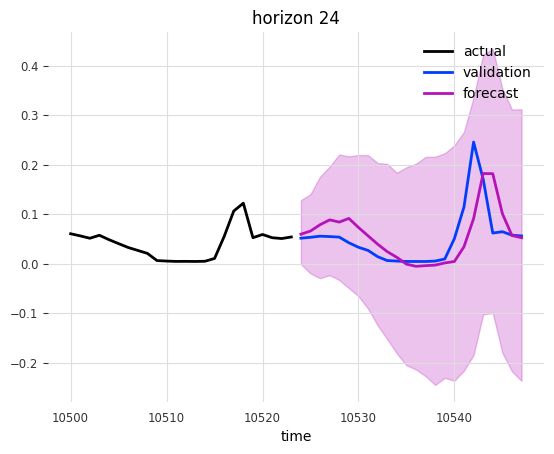

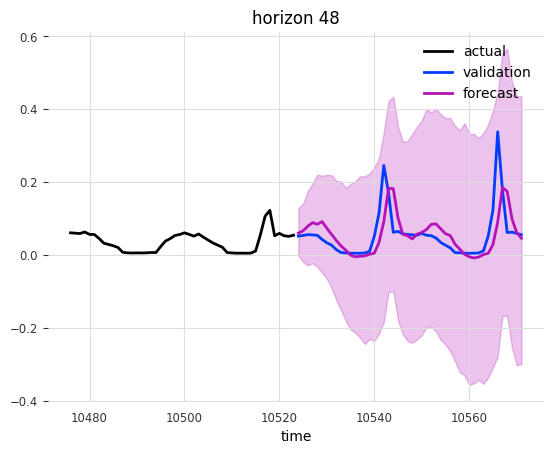

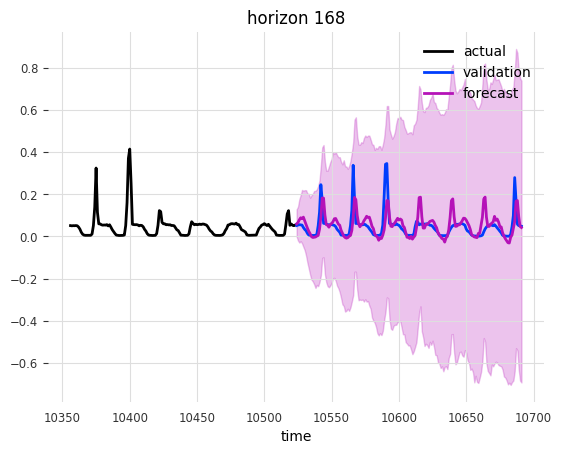

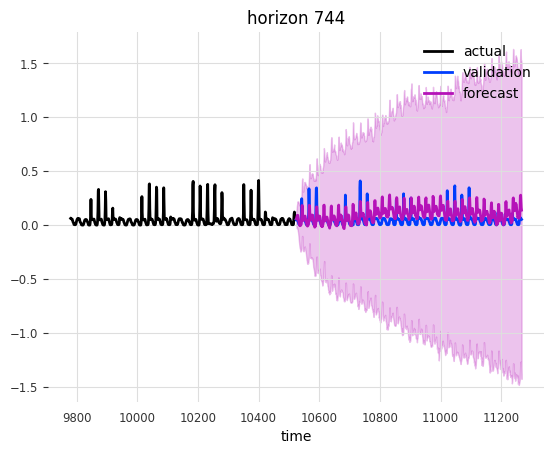

In [9]:
HORIZONS = [24, 24*2, 24*7, 24*31]

for horizon in HORIZONS:
    model = ExponentialSmoothing(**params)
    model.fit(train)
    forecast = model.predict(n=horizon, num_samples=500)

    train[-horizon:].plot(label='actual')
    valid[:horizon].plot(label='validation')
    forecast.plot(label='forecast')
    plt.title(f'horizon {horizon}')
    plt.show()

## Notes

**This model is great with predeterminted features**:
Given a known seasonality, this model is kinda cracked

**Bad for long horizons**
Hallucinates trends where there are none